In [1]:
import pandas as pd
import numpy as np
import sklearn
import math
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from scipy import stats
import seaborn as sns

In [2]:
df=pd.read_csv("stockdata3.csv")
starting_day=pd.to_datetime('2020-05-04T00:00')
df['dtime']=starting_day
df['day']=df['day'].apply(lambda day: pd.Timedelta(days=day-1))
df['timestr']=df['timestr'].apply(lambda time: pd.Timedelta(time))
df['dtime']=df['dtime']+df['day']+df['timestr']
df.set_index('dtime',inplace=True)

In [3]:
stocks=['a','b','c','d','e','f']

let's replace day+time with a single datetime column. To do so, fix a day that corresponds to day 1 (from examining the data, it should be Monday), then add a day and time to that timestamp. I chose first Monday of May 2020 (you can probably figure out exact time period by holidays, but for the purpose of the exercise doesn't seem to be important).

Sampling over as much as possible should give us more robust estimates, but might be sensitive to various noise sources. The common compromise in literature seems to use 5 minute intervals, but it probably highly depends on particular stock/reporting system.

We should also think about whether our model performance is evaluated on in-sample or out-of-sample data. While out-of-sample forecasts are much more reflective of model's performances, with only 1 year worth of data and the task of estimating monthly volatility, it seems hard to have a reasonable amount of out-of-sample testing (unless done daily). 

Forecasting volatility in financial markets: A review - ‎Poon

I'm going to predict average daily volatility over the next 30 days. The reason being that the number of trading days in the next month depends on the month/holidays, etc. For a particular month the estimate for monthly volatility would be my estimate times the sqaure root of the number of trading days that month.

In [4]:
df.head()

,day,timestr,a,b,c,d,e,f
dtime,,,,,,,,
2020-05-04 09:30:00,0 days,0 days 09:30:00,325.450,13.795,94.500,49.985,49.93,17.025
2020-05-04 09:31:00,0 days,0 days 09:31:00,325.245,13.890,94.515,49.990,49.96,17.025
2020-05-04 09:32:00,0 days,0 days 09:32:00,325.580,13.905,94.565,49.995,49.96,17.025
2020-05-04 09:33:00,0 days,0 days 09:33:00,325.470,13.955,94.645,50.065,49.92,17.025
2020-05-04 09:34:00,0 days,0 days 09:34:00,325.295,13.975,94.580,50.030,49.90,17.025


In [5]:
df.dtypes

day        timedelta64[ns]
timestr    timedelta64[ns]
a                  float64
b                  float64
c                  float64
d                  float64
e                  float64
f                  float64
dtype: object

In [6]:
df.loc[:,'a':'f'].describe()

,a,b,c,d,e,f
count,98281.000000,98352.000000,98321.000000,98334.000000,98352.000000,96981.000000
mean,363.767737,10.048836,69.445570,49.803747,47.727738,13.204838
std,28.281333,3.332643,28.675762,4.539923,7.053875,2.404705
min,0.000000,4.885000,33.807000,1.000000,38.550000,9.365000
25%,341.785000,6.605000,45.330000,46.175000,42.040000,10.945000
50%,357.915000,10.595000,50.960000,50.105000,45.410000,13.325000
75%,387.890000,13.465000,101.905000,53.735000,51.350000,15.035000
max,426.560000,15.335000,116.385000,62.137000,69.210000,18.815000


We see that 'a' has values of 0 (93 of them to be precise, see below), 'd' has values of 1, and all columns have some missing values. Stocks 'a' to 'e' have relatively little missing values (under 100 for each), but stock 'f' is missing for a sizable part (about 2.5%) of the data. 

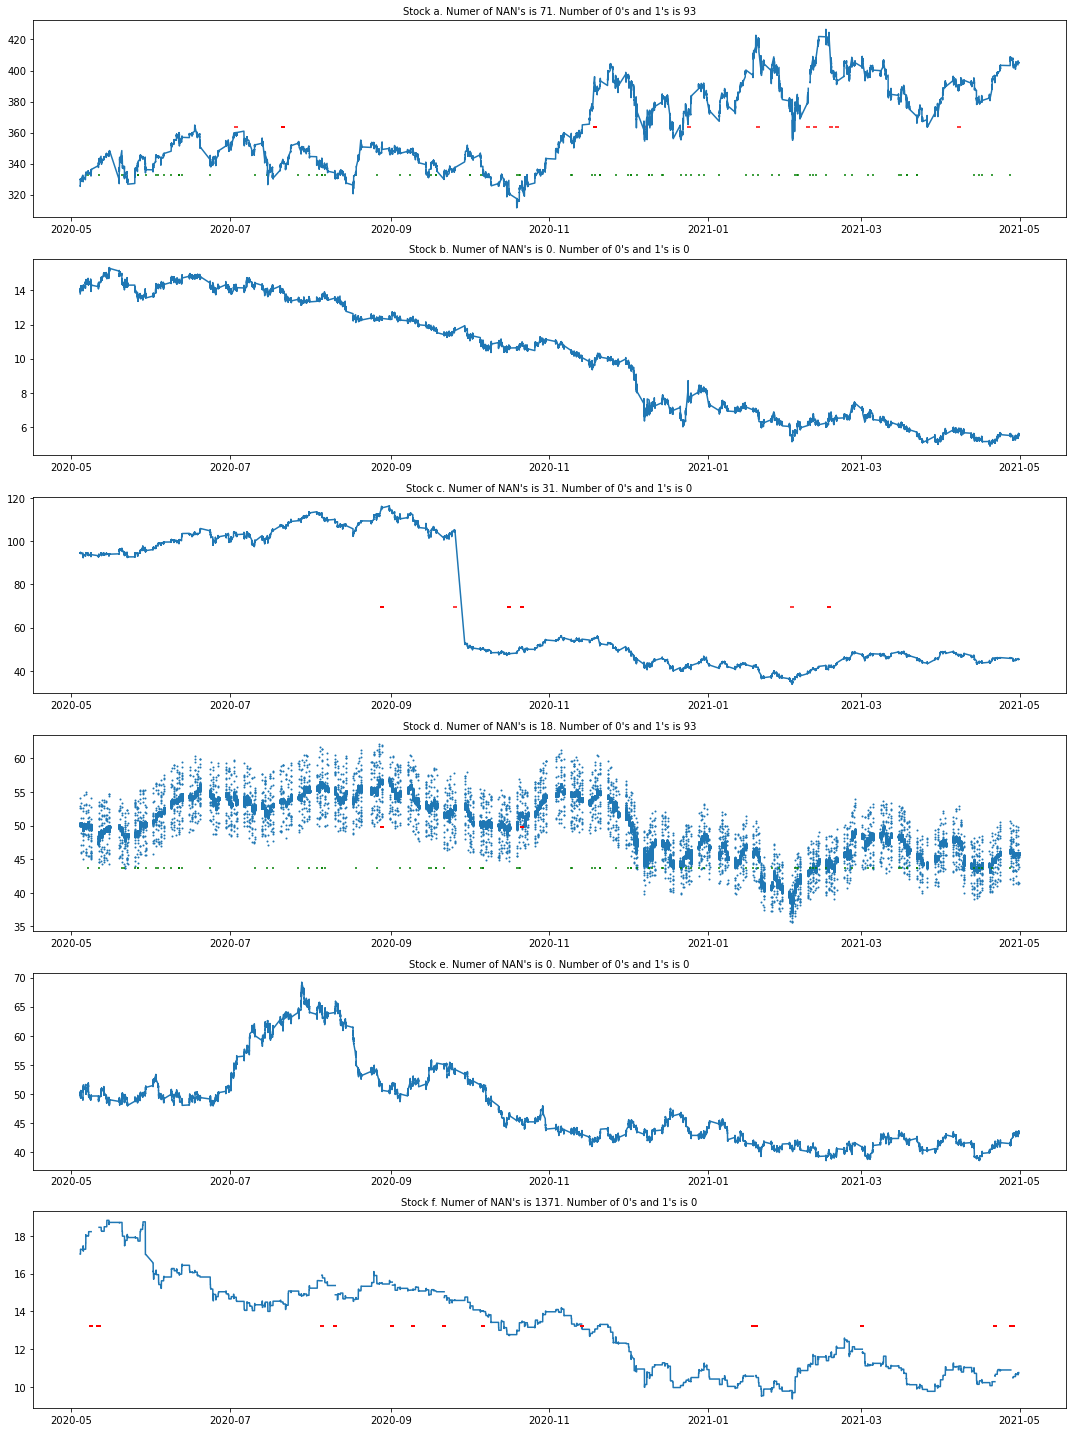

In [7]:
fig,axs=plt.subplots(6,1)
i=0
for stock in stocks:
    nan=df.index[df[stock].isnull()]
    value_0_or_1=df.index[(df[stock]==0) | (df[stock]==1)]
    if stock!='d':
        axs[i].plot(df.loc[(df[stock]!=0) & (df[stock]!=1),stock])
    else:
        axs[i].scatter(df.index[(df[stock]!=0) & (df[stock]!=1)],df.loc[(df[stock]!=0) & (df[stock]!=1),stock], s=1)
    axs[i].scatter(nan,[df[stock].mean()]*len(nan), s=10, c='red', marker="_")
    axs[i].scatter(value_0_or_1,[(-df[stock].max()+3*df[stock].mean())/2]*len(value_0_or_1), s=7, c='green', marker="|")
    axs[i].set_title("Stock "+stock+". Numer of NAN's is "+str(len(nan))+". Number of 0's and 1's is "+str(df.loc[((df[stock]==0) | (df[stock]==1)),stock].count()) ,fontsize=10)
    i+=1
fig.set_size_inches(15,20)
fig.tight_layout()

Visually it looks like 'b', 'c', 'e', 'f' are pretty stable (besides a really big drop in 'c' and a couple of smaller dropps/raises in other places).

Stock 'a' seems to be somewhat volitile, and 'd' looks extremely volitile within small intervals of time, while having a pretty consistent moving average. Also decided to scatterplot 'd' to have a better idea of how prices are distributed, it looks like most points are closer to the moving average than it seemed from a normal graph, with still a sizable part varying strongly.

Maybe we should drop weekends for better graphs?

Curious that 'a' and 'd' has the same number of (obviously) incorrectly recorded points. Might be worth looking whether those occured at the same time.

In [8]:
(1-(df.loc[df['a']==0].index==df.loc[df['d']==1].index)).sum()

0

Now, to deal with missing and incorrectly reported prices, I suggest just doing linear interpolation. It seems reasonable for most of the data, since the ammount of data interpolated is small, and doesn't clamp up a lot. One exception is 'f' that has sizable parts of data missing for continuous intervals of time, so it might be better to just not analyze our approach near those missing intervals. 

Maybe a better approach would be to add noise to interpolations with variations computed from data.

Let's interpolate data:

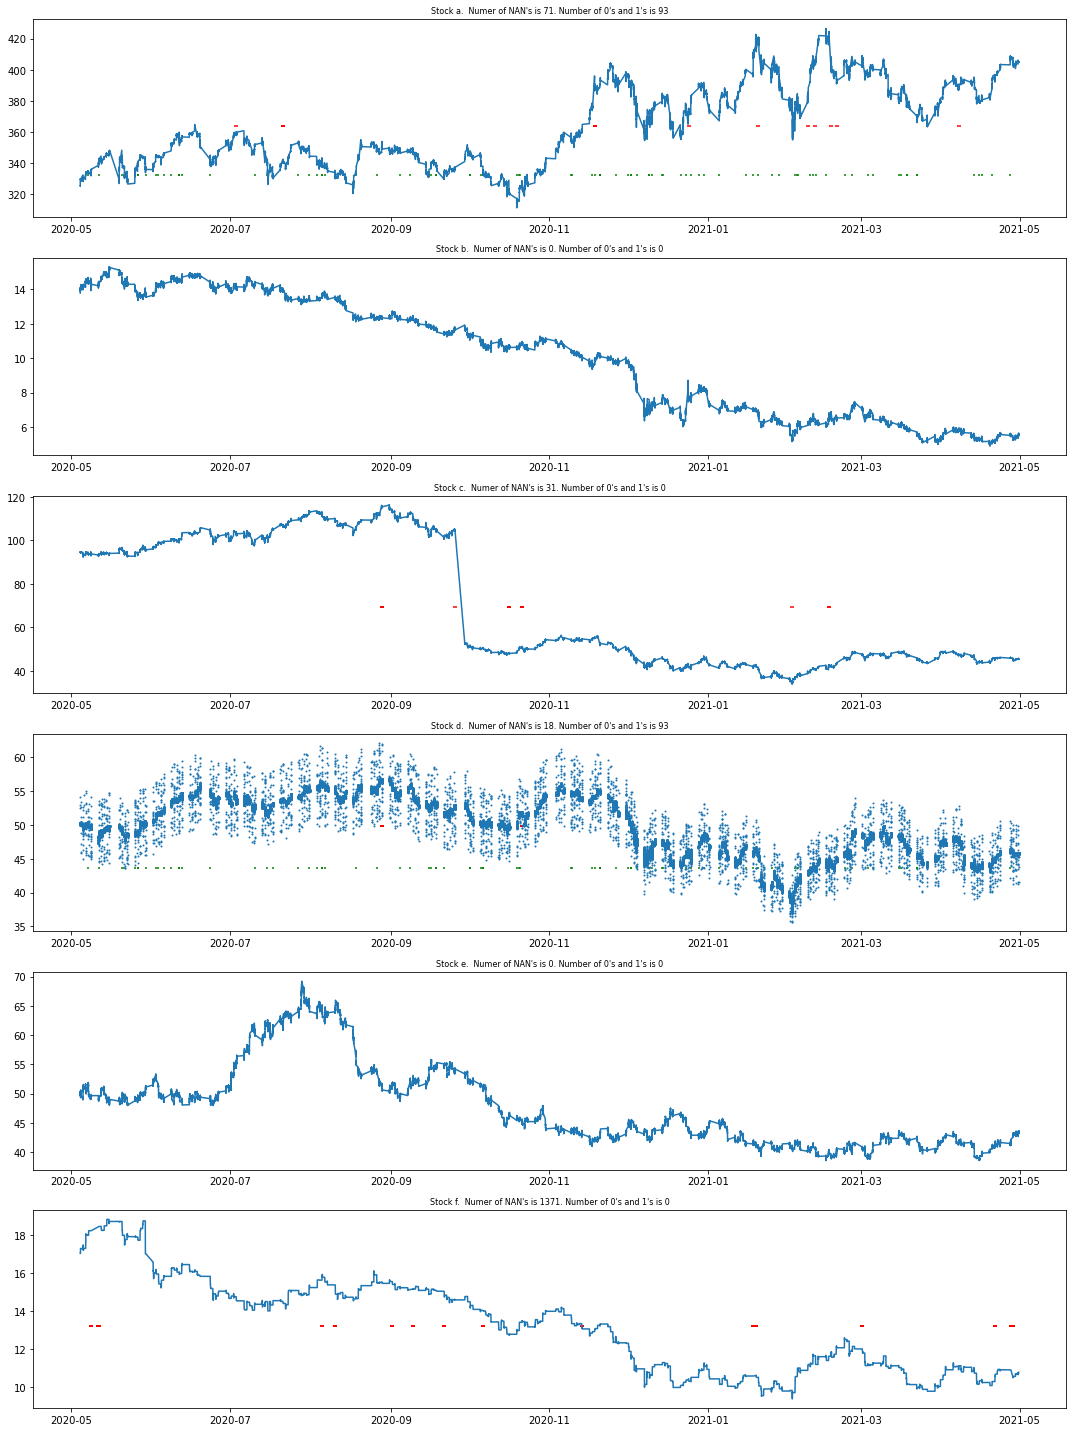

In [9]:
fig,axs=plt.subplots(6,1)
i=0
df_raw=df.copy() ### just creating a copy of raw data in case we need to access nan's etc later.
for x in stocks:
    
    #### plot nan's in red and 0/1s in green (around the mean of each graph)
    nan=df_raw.index[df_raw[x].isnull()]
    value_0_or_1=df.index[(df_raw[x]==0) | (df_raw[x]==1)]
    axs[i].scatter(nan,[df_raw[x].mean()]*len(nan), s=10, c='red', marker="_")
    axs[i].scatter(value_0_or_1,[(-df_raw[x].max()+3*df_raw[x].mean())/2]*len(value_0_or_1), s=7, c='green', marker="|")
    axs[i].set_title("Stock "+x+".  Numer of NAN's is "+str(len(nan))+". Number of 0's and 1's is "+str(len(value_0_or_1)) ,fontsize=8)

    #### Interpolate nan's and 0/1s. Doing it inplance, which might not be ideal if we need raw data again later.
    df.loc[value_0_or_1,x]=float('nan')
    df[x].interpolate(method='time',inplace=True)
    
    #### Plot graphs: normal graphs for all but 'd'
    if x!='d':
        axs[i].plot(df.loc[(df[x]!=0) & (df[x]!=1),x])
    else:
        axs[i].scatter(df.index[(df[x]!=0) & (df[x]!=1)],df.loc[(df[x]!=0) & (df[x]!=1),x], s=1)
    
    i+=1
fig.set_size_inches(15,20)
fig.tight_layout()
    


Now let's resample to 5-minute intervals (with mean over those 5 minute intervals as the resampling function).

In [10]:
df_5_min=df.resample('5T').mean()
df_5_min=df_5_min.join(df,  how='inner', rsuffix='_old').loc[:,['day','timestr','a','b','c','d','e','f']]

In [11]:
df_5_min.head()

,day,timestr,a,b,c,d,e,f
dtime,,,,,,,,
2020-05-04 09:30:00,0 days,0 days 09:30:00,325.408,13.904,94.561,50.013,49.934,17.025
2020-05-04 09:35:00,0 days,0 days 09:35:00,325.745,13.963,94.574,50.061,49.976,17.025
2020-05-04 09:40:00,0 days,0 days 09:40:00,326.890,14.023,94.610,50.139,49.884,17.025
2020-05-04 09:45:00,0 days,0 days 09:45:00,327.540,13.945,94.653,50.226,49.820,17.025
2020-05-04 09:50:00,0 days,0 days 09:50:00,327.492,13.909,94.644,50.259,49.948,17.025


Let's compute the log returns. We can either use percent change (p(t+1)-p(t))/p(t). They are pretty close (for small changes), but it is convinient to have additive property.

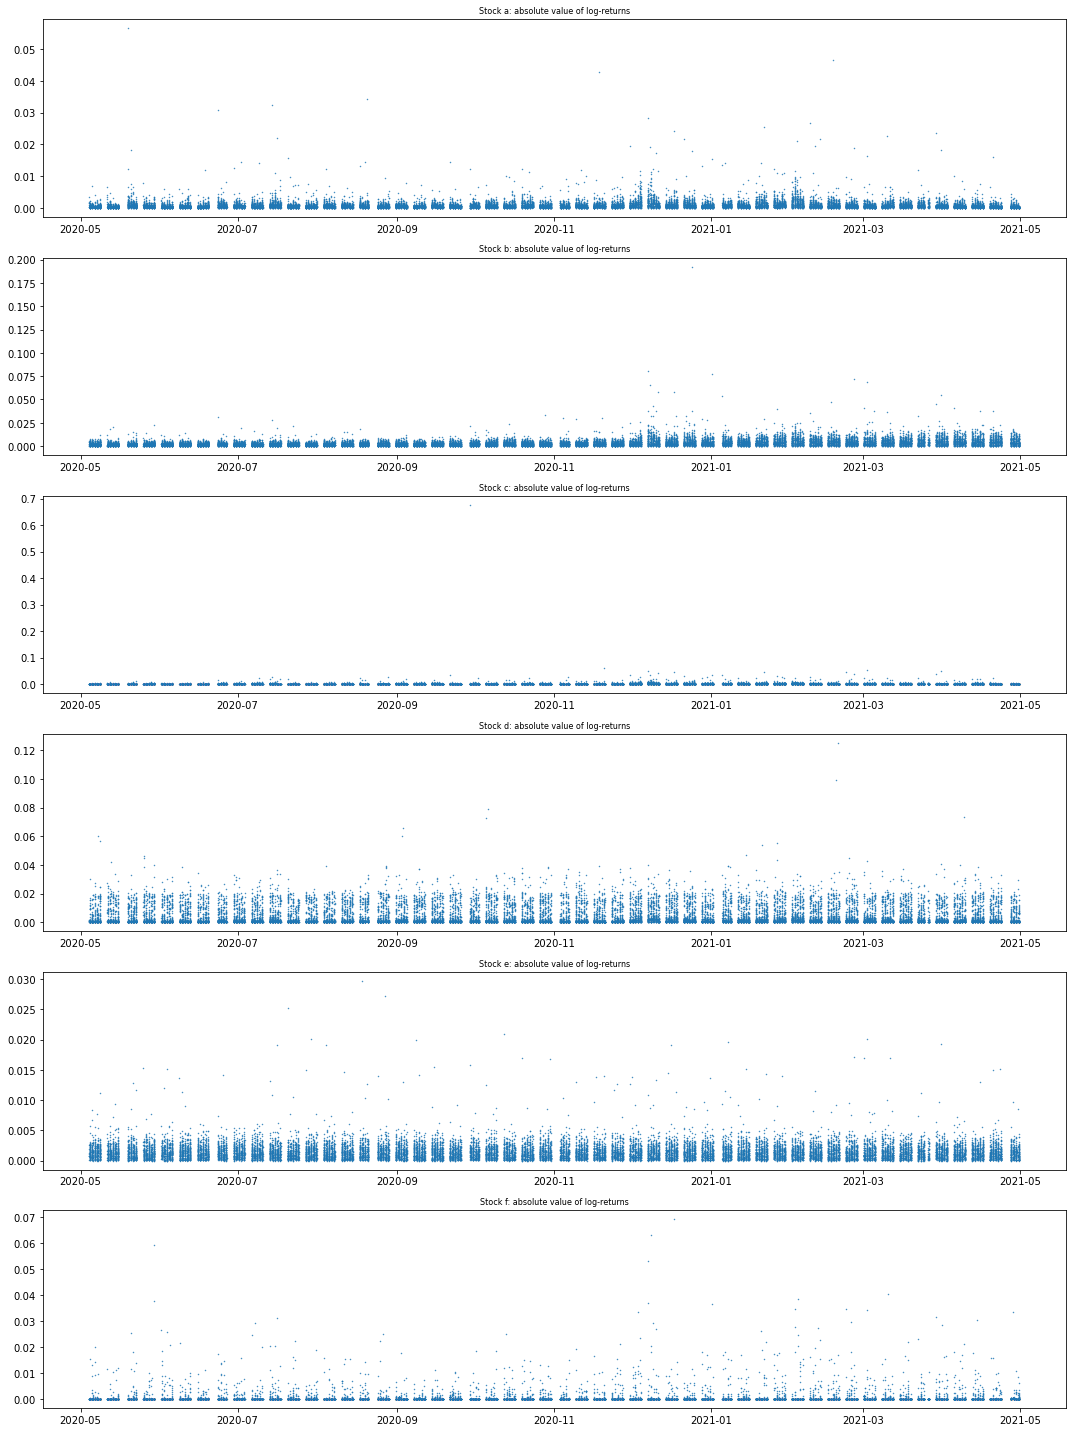

In [12]:
log_returns=pd.DataFrame(index=df_5_min.index)
for stock in stocks:
    log_returns[stock]=np.log(df_5_min[stock]).diff()
log_returns['day']=df_5_min['day']
    
fig_log, axs=plt.subplots(6,1)
i=0
for stock in stocks:
    axs[i].set_title("Stock "+stock+": absolute value of log-returns", fontsize=8)
    #axs[i].plot(log_returns[stock]*log_returns[stock])
    axs[i].scatter(log_returns.index,np.abs(log_returns[stock]),s=0.2)
    i+=1
fig_log.set_size_inches(15,20)
fig_log.tight_layout()

One extra thing we notice from stock 'f' is the amount of time intervals where the price is constant. This might be due to low trading volume (e.g. if stock is only traded a few times a day). We should account for that when we compute volatility (as if that is the case, constant time intervals represent no trading, not a constant trading price). This can also be observed fromthe figure below.

Similar thing can be seen for stock 'b': there is a clear duality between 0 and non-0 log-returns (and 0 log-returns amount to almost 30% of observations which is still more than one can expect). This again suggests that the periods with 0 returns correspond to no trading events periods, not actually to periods with constant price. ## This is resolved by resampling.

If I am getting this data from an outside source, I would ask for the amount of each stock traded during each time interval to incorporate into volatility model.

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'d'}>],
       [<AxesSubplot:title={'center':'e'}>,
        <AxesSubplot:title={'center':'f'}>]], dtype=object)

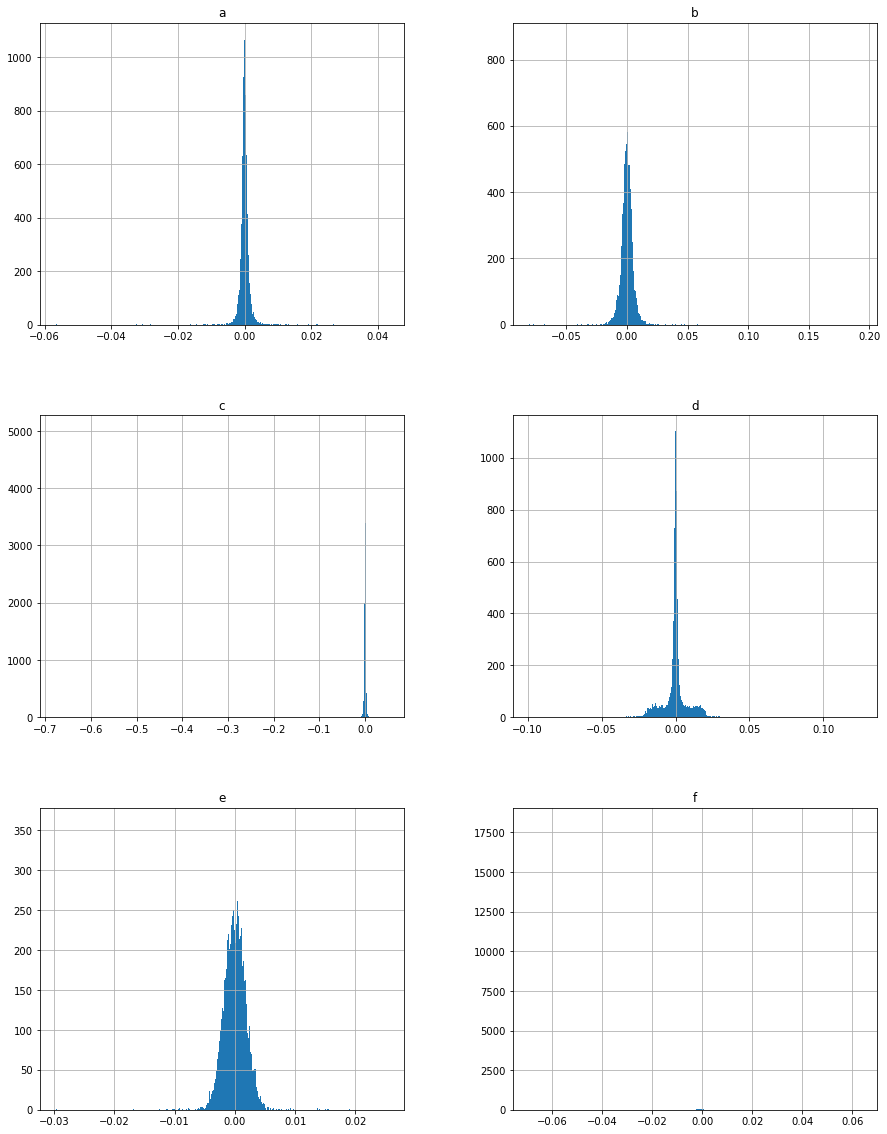

In [13]:
log_returns.loc[:,'a':'f'].hist(layout=(3,2),bins=1000,figsize=(15,20))

In [14]:
amount_of_0=[0]*len(stocks)
i=0
for stock in stocks:
    amount_of_0[i]=round(log_returns.loc[log_returns[stock]==0,stock].size/log_returns.index.size,4)
    i+=1
amount_of_0

[0.0023, 0.0258, 0.0021, 0.0054, 0.0087, 0.9047]

we see that indeed 90% of 'f' log_returns is 0

In raw files, stock 'b' also had way too many 0's, but after resampling, this problem seemed to be fixed

I propose to get rid of 0's in stock 'f' completely. Alternatively, we can only get rid of most of 0's to get the number of no change to be on par with the number of observations of non 0 entries.

Again, one thing to care for here is to double check the sourse of data to see that those no change periods are actually no trading periods.

In [15]:
log_returns.loc[:,'a':'f'].mean()/log_returns.loc[:,'a':'f'].var()

a    3.938703
b   -1.707653
c   -1.277662
d   -0.064443
e   -1.690904
f   -4.923666
dtype: float64

We see that most stocks have substential avg. price changes.

array([[<AxesSubplot:xlabel='dtime'>],
       [<AxesSubplot:xlabel='dtime'>],
       [<AxesSubplot:xlabel='dtime'>],
       [<AxesSubplot:xlabel='dtime'>],
       [<AxesSubplot:xlabel='dtime'>],
       [<AxesSubplot:xlabel='dtime'>]], dtype=object)

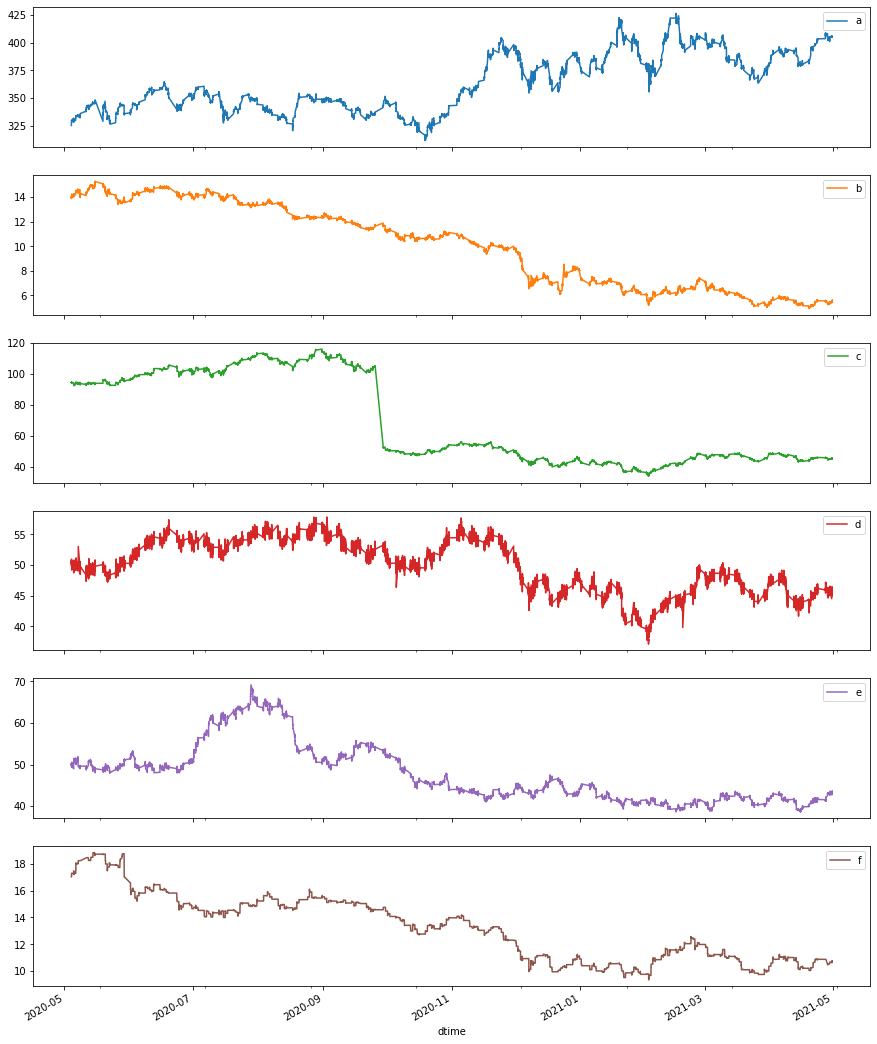

In [16]:
df_5_min.loc[:,'a':'f'].plot(subplots=True, layout=(6,1),figsize=(15,20))

In [17]:
log_returns.describe()

,a,b,c,d,e,f,day
count,19871.000000,19871.000000,19871.000000,19871.000000,19871.000000,19871.000000,19872
mean,0.000011,-0.000046,-0.000037,-0.000004,-0.000007,-0.000023,180 days 07:12:01.739130434
std,0.001672,0.005174,0.005384,0.008336,0.002001,0.002167,104 days 14:52:53.334428426
min,-0.056551,-0.080619,-0.676460,-0.098887,-0.029644,-0.069025,0 days 00:00:00
25%,-0.000538,-0.002563,-0.000834,-0.001535,-0.001191,0.000000,88 days 00:00:00
50%,0.000003,0.000000,-0.000004,-0.000019,0.000000,0.000000,179 days 00:00:00
75%,0.000548,0.002498,0.000804,0.001460,0.001192,0.000000,270 days 00:00:00
max,0.042774,0.192560,0.048259,0.124918,0.025258,0.063149,361 days 00:00:00


<AxesSubplot:>

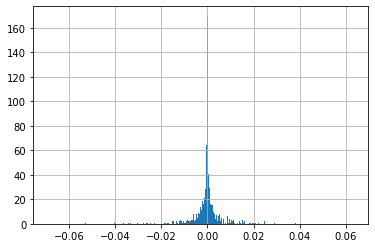

In [18]:
log_returns.loc[log_returns['f']==0,'f']=np.nan
log_returns['f'].hist(bins=1000)

This seems like a much more likely distribution of log-returns.

Let's compute daily variance squared:

In [19]:
daily_var=log_returns.groupby(by='day', as_index=False).var(ddof=1)  #### degrees of freedom 0 for an easier formula/better interpretation. Using standard ddof=1 wouldn't change the results much.

#daily_vol=daily_var.copy()
#daily_vol.loc[:,'a':'f']=daily_vol.loc[:,'a':'f'].pow(0.5)

#If we want to use realized volatility. Results seem to be similar.
log_returns_sq=log_returns.copy()
log_returns_sq.loc[:,'a':'f']=log_returns_sq.loc[:,'a':'f'].pow(2)
daily_vol=log_returns_sq.groupby(by='day', as_index=False).sum()
daily_vol.loc[:,'a':'f']=daily_vol.loc[:,'a':'f'].pow(0.5)

daily_vol.set_index(np.unique(df.index.date),inplace=True)
daily_var.set_index(np.unique(df.index.date),inplace=True)

array([[<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>]], dtype=object)

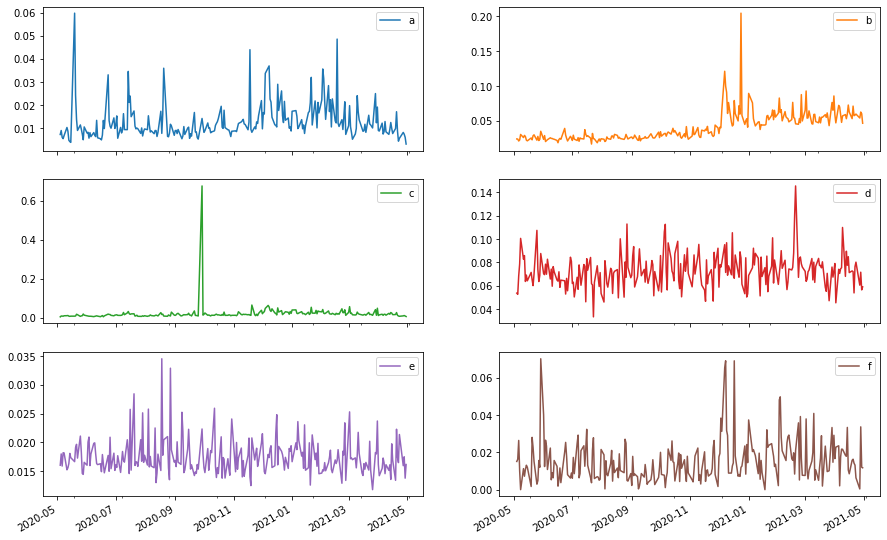

In [20]:
daily_vol.loc[:,'a':'f'].plot(subplots=True, layout=(3,2),figsize=(15,10)) 

I would have expected more persistent behaviour. With the way it looks, I would say that simple moving mean or historic mean might be a good model in most cases, due to lack of aucorrelation (reflected in the lack of consistent intervals of high/low volatility on the graph above).

In [21]:
daily_vol.head()

,day,a,b,c,d,e,f
2020-05-04,0 days,0.007262,0.023997,0.004995,0.053674,0.015997,0.015162
2020-05-05,1 days,0.008990,0.023838,0.009227,0.052681,0.017965,0.016337
2020-05-06,2 days,0.006045,0.021054,0.009117,0.068450,0.015850,0.026422
2020-05-07,3 days,0.005465,0.022541,0.008285,0.078706,0.018173,0.010093
2020-05-08,4 days,0.006773,0.030435,0.010541,0.100542,0.018140,0.000061


In [22]:
daily_avg=df_5_min.groupby(by='day', as_index=False).mean()
daily_return=log_returns.groupby(by='day', as_index=False).sum() 
daily_avg.set_index(np.unique(df.index.date),inplace=True)
daily_return.set_index(np.unique(df.index.date),inplace=True)

In [23]:
daily_vol.corrwith(daily_avg)

a    0.166234
b   -0.740078
c   -0.153644
d   -0.149644
e    0.116766
f   -0.245238
dtype: float64

In [24]:
daily_vol.corrwith(daily_return)

a   -0.125505
b    0.012486
c   -0.862095
d    0.001199
e   -0.146995
f   -0.187657
dtype: float64

In [25]:
daily_vol.corr()

,a,b,c,d,e,f
a,1.000000,0.384350,0.140489,0.143019,0.006094,0.362691
b,0.384350,1.000000,0.127394,0.155852,-0.024492,0.376300
c,0.140489,0.127394,1.000000,-0.050269,0.110646,0.063722
d,0.143019,0.155852,-0.050269,1.000000,0.150062,0.018421
e,0.006094,-0.024492,0.110646,0.150062,1.000000,-0.078352
f,0.362691,0.376300,0.063722,0.018421,-0.078352,1.000000


we see that maybe a,b,f are somewhat correlated, but the rest seem to not be.

Need to take care because 'c' correlation with daily return is likely due to the price drop 

looking at the autocorrelation plots, only stock's ''b' daily variation seems to have some significant autocorrelation.
#### Need to clean 'c' data

fig_acorr, axs = plt.subplots(3,2,tight_layout=True, sharex=False,sharey=False,figsize=(15,20))
i=0
j=0
for stock in stocks:
    axs[i][j].set_title("Stock "+stock+": daily variance autocorrelation", fontsize=8)
    axs[i][j].acorr(daily_var[stock], normed=False,maxlags=250)
    if j==1:
        j=0
        i+=1
    else:
        j+=1
        
        ###### aparently matplotlib acorr doesn't work..

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

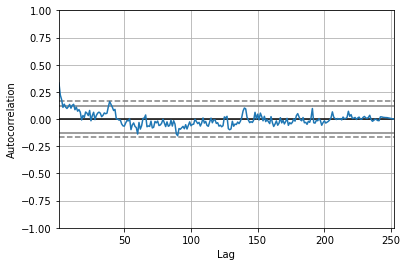

In [26]:
pd.plotting.autocorrelation_plot(daily_vol['a'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

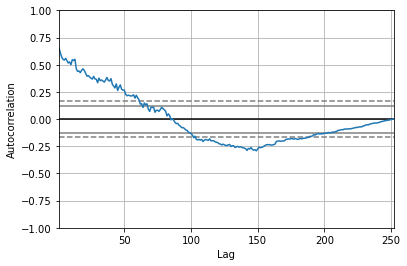

In [27]:
pd.plotting.autocorrelation_plot(daily_vol['b'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

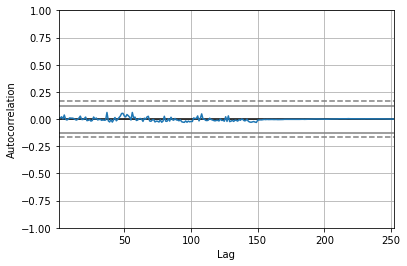

In [28]:
pd.plotting.autocorrelation_plot(daily_vol['c'])

In [29]:
daily_vol['c_no_extremes']=daily_vol['c']
daily_vol.loc[daily_vol['c_no_extremes'].idxmax(),'c_no_extremes']= daily_vol['c_no_extremes'].nlargest(2).iloc[-1] ### or =np.nan if we want to remove it. 
stocks_and_c_no_extremes=stocks.copy()
stocks_and_c_no_extremes.append('c_no_extremes')

<AxesSubplot:>

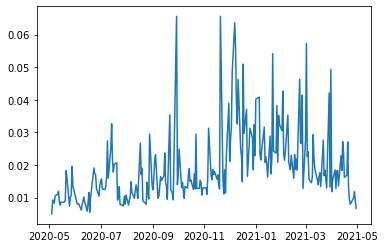

In [30]:
daily_vol['c_no_extremes'].plot()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

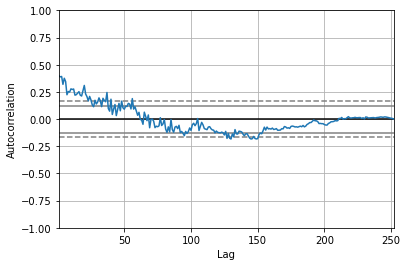

In [31]:
pd.plotting.autocorrelation_plot(daily_vol['c_no_extremes'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

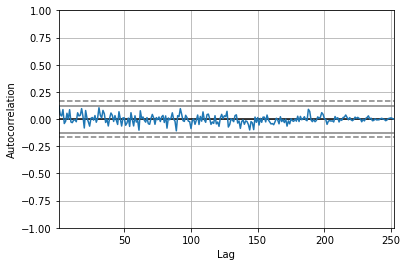

In [32]:
pd.plotting.autocorrelation_plot(daily_vol['d'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

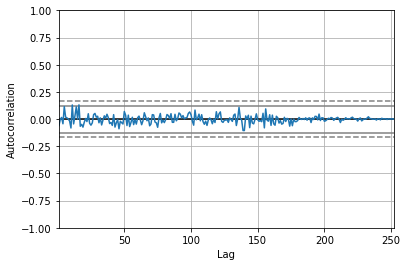

In [33]:
pd.plotting.autocorrelation_plot(daily_vol['e'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

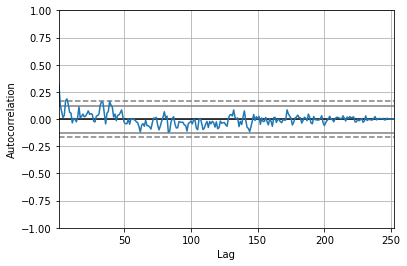

In [34]:
pd.plotting.autocorrelation_plot(daily_vol['f'])

In [35]:
for stock in stocks: 
    daily_vol[stock+'_prev']=daily_vol[stock].shift(periods=-1)
daily_vol.head()

,day,a,b,c,d,e,f,c_no_extremes,a_prev,b_prev,c_prev,d_prev,e_prev,f_prev
2020-05-04,0 days,0.007262,0.023997,0.004995,0.053674,0.015997,0.015162,0.004995,0.008990,0.023838,0.009227,0.052681,0.017965,0.016337
2020-05-05,1 days,0.008990,0.023838,0.009227,0.052681,0.017965,0.016337,0.009227,0.006045,0.021054,0.009117,0.068450,0.015850,0.026422
2020-05-06,2 days,0.006045,0.021054,0.009117,0.068450,0.015850,0.026422,0.009117,0.005465,0.022541,0.008285,0.078706,0.018173,0.010093
2020-05-07,3 days,0.005465,0.022541,0.008285,0.078706,0.018173,0.010093,0.008285,0.006773,0.030435,0.010541,0.100542,0.018140,0.000061
2020-05-08,4 days,0.006773,0.030435,0.010541,0.100542,0.018140,0.000061,0.010541,0.010296,0.025963,0.011043,0.082698,0.015200,0.011328


In [36]:
def model_historic_mean(df, stock, lookback_interval=10, prediction_interval=30):
    return ((df[stock]**2).mean())**(0.5)
#def model_historic_mean_exclude_extreme(df, stock, lookback_interval=10, prediction_interval=30):
    #return df.loc[df[stock]<=df.nlargest(1,stock).iloc[-1,:][stock],stock].mean()
def model_moving_avg(df, stock, lookback_interval=10, prediction_interval=30):
    return (((df.loc[df.index+pd.Timedelta(days=lookback_interval)>df.index[-1],stock])**2).mean())**(0.5)

def model_exponential_decay(df, stock, lookback_interval=30, prediction_interval=30):
                            #### lookback interval=number of days after which the weight is halfed (i.e. gamma=1/2^(1/lookback_interval))
    gamma=2**(-1/lookback_interval)
    gamma_ar=gamma**(len(df.index)-np.arange(len(df.index))-1)
    return (((df[stock]**2)*gamma_ar).sum()/gamma_ar.sum())**0.5

##def model_exponential_decay_exclude_extreme(df, stock, lookback_interval=30, prediction_interval=30):
                            #### lookback interval=number of days after which the weight is halfed (i.e. gamma=1/2^(1/lookback_interval))
    ##df_exclude_extremes=df[stock]


In [37]:
def test_model(model, df, prediction_interval=30,stocks_f=df.columns, min_days=60, error_method='Raw error', lookback_interval=10):  
                           #### I'm mainly planning to use meam squared error to compare models.
                           #### Other error function: 'Relative error' (error/observed value)
                           #### prediction_interval is the number of days to predict ahead. We can do it in months (using numpy datetime instead of pandas),
                           #### but it doesn't really make sense, since we set up an arbitrary starting date anyway.
                           #### stocks_f is the stocks we want to predict
                           #### min_days is the minimal number of days required to give an estimate
                          
    number_of_months=int((df.index[-1]-df.index[0]-pd.Timedelta(days=min_days))/pd.Timedelta(days=prediction_interval))    
    prediction_error=pd.DataFrame(columns=stocks_f, index=np.arange(number_of_months))
    for stock in stocks_f:
        day=df.index[-1]
        i=0
        while day>df.index[0]+pd.Timedelta(days=min_days):
            first_day=df.loc[df.index+pd.Timedelta(days=prediction_interval)>day].index[0]
            pred=model(df=df.loc[df.index<first_day], stock=stock, prediction_interval=prediction_interval, lookback_interval=lookback_interval)
            obs=(df.loc[((df.index>=first_day) & (df.index<=day)),stock].pow(2).mean())**(1/2)
            if error_method=='Raw error':
                prediction_error.loc[number_of_months-i-1,stock]=pred-obs
            if error_method=='Relative error':
                prediction_error.loc[number_of_months-i-1,stock]=(pred-obs)/obs
            i+=1
            day=df.loc[df.index<first_day].index[-1]
            
    return prediction_error
            

In [38]:
def total_error(model, df, prediction_interval=30,stocks_f=df.columns, min_days=60, error_method='Raw error', lookback_interval=10):
       if error_method=='Raw error':
            return test_model(model, df, prediction_interval,stocks_f, min_days, error_method, lookback_interval).abs().mean()/df[stocks_f].mean()
       elif error_method=='Relative error':
            return test_model(model, df, prediction_interval,stocks_f, min_days, error_method, lookback_interval).abs().mean()

In [39]:
test_model(model_historic_mean, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error')

,a,b,c,d,e,f,c_no_extremes
0,-0.00547186,-0.00500189,-0.327915,0.0790623,-0.068332,0.0827515,-0.327915
1,0.109493,-0.0197969,-0.0845222,-0.0363525,-0.107211,0.318598,-0.0845222
2,0.524056,-0.0327945,-0.907557,-0.03507,0.0262775,1.00507,-0.366624
3,0.179786,-0.191489,3.26924,-0.107714,0.0437376,0.142802,-0.0145661
4,-0.174363,-0.218718,1.6336,-0.00402569,0.0569349,0.214826,-0.333015
5,-0.359512,-0.636835,0.656527,-0.0527111,-0.00800478,-0.504245,-0.516819
6,-0.112223,-0.30339,0.90865,-0.0258152,-0.0181441,-0.062981,-0.304705
7,-0.323863,-0.32186,0.969708,-0.110426,0.0587937,-0.274322,-0.20849
8,0.112327,-0.287148,0.999477,0.0426117,0.0103351,-0.0511303,-0.140406
9,0.643355,-0.253048,1.96902,0.00446063,0.0760808,0.0641949,0.343346


we see that expectedly, simple historic mean assigns too much value to hitoric behaviour (e.g. last prediction of 'a' is )

We also see (again expectedly), that 'c' predictions are extremely unnacurate after big drop. 

In [40]:
error_df=pd.DataFrame(index=stocks_and_c_no_extremes)

In [41]:
error_df['tae HM']=total_error(model_historic_mean, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error')
total_error(model_historic_mean, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error')

a                0.272404
b                0.322739
c                1.706038
d                0.051966
e                0.048735
f                0.295702
c_no_extremes    0.340161
dtype: float64

In [42]:
error_df['tre HM']=total_error(model_historic_mean, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error')
total_error(model_historic_mean, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error')

a                0.254445
b                0.227008
c                1.172622
d                0.049825
e                0.047385
f                0.272092
c_no_extremes    0.264041
dtype: float64

In [43]:
test_model(model_moving_avg, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error',lookback_interval=20)

,a,b,c,d,e,f,c_no_extremes
0,-0.0613374,0.000897416,-0.243189,0.00863219,-0.107667,-0.260066,-0.243189
1,0.210053,-0.00205581,0.134831,-0.0711062,-0.0249596,0.215673,0.134831
2,0.534537,0.0147866,-0.890277,0.0235286,0.146908,0.609926,-0.248233
3,-0.129651,-0.149222,10.8501,-0.130132,-0.010758,-0.357557,0.543547
4,-0.239119,-0.0724017,-0.322631,0.0471273,0.034126,0.131987,-0.322631
5,-0.173467,-0.551728,-0.277841,-0.083514,-0.0495056,-0.582225,-0.277841
6,0.0302736,0.426088,0.0385266,0.00209129,-0.00630467,0.171339,0.0385266
7,-0.208455,-0.123924,0.0636163,-0.0985682,0.0363844,-0.297134,0.0636163
8,0.392004,-0.0417586,0.00956566,0.203217,-0.00784689,0.101135,0.00956566
9,0.463389,-0.00725581,0.432439,-0.031671,0.020658,0.0369543,0.432439


In [44]:
error_df['tae MM (d=10)']=total_error(model_moving_avg, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error',lookback_interval=10)
total_error(model_moving_avg, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error',lookback_interval=10)

a                0.208365
b                0.233661
c                1.985420
d                0.075687
e                0.060590
f                0.299107
c_no_extremes    0.385324
dtype: float64

In [45]:
error_df['tre MM (d=10)']=total_error(model_moving_avg, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error',lookback_interval=10)
total_error(model_moving_avg, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error',lookback_interval=10)

a                0.196004
b                0.169070
c                1.840824
d                0.073376
e                0.058931
f                0.264051
c_no_extremes    0.353299
dtype: float64

In [46]:
test_model(model_exponential_decay, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error',lookback_interval=30)

,a,b,c,d,e,f,c_no_extremes
0,-0.0280424,-0.00375265,-0.309227,0.0693544,-0.0712569,0.0549341,-0.309227
1,0.0889812,-0.0216945,-0.0307036,-0.0539291,-0.0945549,0.272332,-0.0307036
2,0.48371,-0.0281879,-0.902041,-0.0330592,0.0612464,0.868718,-0.328831
3,0.074496,-0.18127,5.73591,-0.103102,0.0572936,-0.0330937,0.15667
4,-0.250734,-0.169796,2.48629,0.0253545,0.0556658,0.0628951,-0.263221
5,-0.352197,-0.598418,0.881516,-0.0342417,-0.0205419,-0.564123,-0.425429
6,0.0129667,0.00646494,0.898332,-0.00244839,-0.0237722,0.117433,-0.0798733
7,-0.23791,-0.0762599,0.733433,-0.0901076,0.0578446,-0.177461,0.0269493
8,0.322378,-0.0526938,0.575034,0.0985434,-0.00235255,0.107138,0.0728899
9,0.80603,-0.0257129,1.12554,0.025358,0.0634714,0.19099,0.608419


In [47]:
error_df['tae ED (d=30)']=total_error(model_exponential_decay, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error',lookback_interval=30)
total_error(model_exponential_decay, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error',lookback_interval=30)

a                0.276471
b                0.167629
c                1.862031
d                0.055203
e                0.052181
f                0.283100
c_no_extremes    0.270277
dtype: float64

In [48]:
error_df['tre ED (d=30)']=total_error(model_exponential_decay, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error',lookback_interval=30)
total_error(model_exponential_decay, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Relative error',lookback_interval=30)

a                0.265745
b                0.116425
c                1.367803
d                0.053550
e                0.050800
f                0.244912
c_no_extremes    0.230221
dtype: float64

In [49]:
error_df

,tae HM,tre HM,tae MM (d=10),tre MM (d=10),tae ED (d=30),tre ED (d=30)
a,0.272404,0.254445,0.208365,0.196004,0.276471,0.265745
b,0.322739,0.227008,0.233661,0.169070,0.167629,0.116425
c,1.706038,1.172622,1.985420,1.840824,1.862031,1.367803
d,0.051966,0.049825,0.075687,0.073376,0.055203,0.053550
e,0.048735,0.047385,0.060590,0.058931,0.052181,0.050800
f,0.295702,0.272092,0.299107,0.264051,0.283100,0.244912
c_no_extremes,0.340161,0.264041,0.385324,0.353299,0.270277,0.230221


In [50]:
predictions=pd.DataFrame(index=stocks)
predictions['prediction']=np.nan

In [51]:
for stock in ['a','d','e','f']:
    predictions.loc[stock,'prediction']=model_historic_mean(daily_vol, stock=stock)
predictions.loc['b','prediction']=model_exponential_decay(daily_vol,stock='b',lookback_interval=30)
predictions.loc['c','prediction']=model_exponential_decay(daily_vol,stock='c_no_extremes',lookback_interval=30)
predictions

,prediction
a,0.014847
b,0.058591
c,0.023441
d,0.074020
e,0.017766
f,0.019241


In [52]:
predictions=predictions*(253**(1/2))*100
predictions

,prediction
a,23.615684
b,93.195133
c,37.285642
d,117.736647
e,28.258643
f,30.604369


In [53]:
std_dev=pd.DataFrame(index=stocks)
std_dev['std']=np.nan
std_dev.loc[['a','d','e','f'],'std']=(test_model(model_historic_mean, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error').var()).loc[['a','d','e','f']]
std_dev.loc['b','std']=(test_model(model_exponential_decay, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error').var()).loc['b']
std_dev.loc['c','std']=(test_model(model_exponential_decay, daily_vol, stocks_f=stocks_and_c_no_extremes, error_method='Raw error').var()).loc['c_no_extremes']
std_dev

,std
a,0.000020
b,0.000231
c,0.000044
d,0.000021
e,0.000001
f,0.000045


In [54]:
std_dev=(std_dev**(0.5))*(253**(1/2))*100
std_dev

,std
a,7.101289
b,24.199244
c,10.542624
d,7.206323
e,1.725552
f,10.715602


In [55]:
predictions['prediction']-2*std_dev['std']

a      9.413107
b     44.796644
c     16.200394
d    103.324002
e     24.807539
f      9.173164
dtype: float64

In [56]:
predictions['prediction']+2*std_dev['std']

a     37.818261
b    141.593622
c     58.370890
d    132.149293
e     31.709747
f     52.035573
dtype: float64